In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstalling torc

In [ ]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f1c602327801d09307cbea10c757998175ad35a5f77406b73aa5e5e2f5759c68
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import os
import random
import shutil

# Definir diretórios de origem e destino
diretorio_origem = '/content/drive/MyDrive/DATASET'

diretorio_destino_treino = 'DATASET/dataset_treino'
diretorio_destino_teste = 'DATASET/dataset_teste'


# Criar diretórios de destino se não existirem
if not os.path.exists(diretorio_destino_treino):
    os.makedirs(diretorio_destino_treino)

if not os.path.exists(diretorio_destino_teste):
    os.makedirs(diretorio_destino_teste)

# Lista das classes
classes = ['MATURE', 'IMMATURE']

# Iterar sobre as classes
for classe in classes:
    diretorio_origem_classe = os.path.join(diretorio_origem, classe)
    diretorio_destino_treino_classe = os.path.join(diretorio_destino_treino, classe)
    diretorio_destino_teste_classe = os.path.join(diretorio_destino_teste, classe)

    # Criar diretórios de destino para a classe se não existirem
    if not os.path.exists(diretorio_destino_treino_classe):
        os.makedirs(diretorio_destino_treino_classe)

    if not os.path.exists(diretorio_destino_teste_classe):
        os.makedirs(diretorio_destino_teste_classe)

    # Obter lista de imagens da classe
    imagens = os.listdir(diretorio_origem_classe)

    # Calcular quantidade de imagens para treinamento e teste
    qtd_treino = int(len(imagens) * 0.8)

    # Selecionar imagens de treinamento aleatoriamente
    imagens_treino = random.sample(imagens, qtd_treino)

    # Mover imagens de treinamento para o diretório de destino
    for imagem in imagens_treino:
        origem = os.path.join(diretorio_origem_classe, imagem)
        destino = os.path.join(diretorio_destino_treino_classe, imagem)
        shutil.copy(origem, destino)

    # Mover imagens restantes para o diretório de teste
    for imagem in imagens:
        if imagem not in imagens_treino:
            origem = os.path.join(diretorio_origem_classe, imagem)
            destino = os.path.join(diretorio_destino_teste_classe, imagem)
            shutil.copy(origem, destino)

print("Conjuntos de treinamento e teste criados com sucesso!")

Conjuntos de treinamento e teste criados com sucesso!


In [ ]:
import os
import random
import time
import datetime
import copy
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

from efficientnet_pytorch import EfficientNet

import torch
from torch import nn, optim
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
from PIL import Image, ImageFile

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def inicializar_modelo(nome_modelo, num_classes):
    modelo = None
    tamanho_entrada = 0

    if nome_modelo == "alexnet":
        modelo = models.alexnet(weights='DEFAULT')
        num_ftrs = modelo.classifier[6].in_features
        modelo.classifier[6] = nn.Linear(num_ftrs, num_classes)
        tamanho_entrada = 224

    elif nome_modelo == "vgg":
        modelo = models.vgg16(weights='DEFAULT')
        num_ftrs = modelo.classifier[6].in_features
        modelo.classifier[6] = nn.Linear(num_ftrs, num_classes)
        tamanho_entrada = 224

    else:
        print("Nome de modelo inválido, saindo...")
        exit()

    return modelo, tamanho_entrada

In [ ]:
def treinar_modelo(modelo, dataloaders, otimizador, parametros_basicos, fold, data_atual, dispositivo='gpu'):
    desde = time.time()

    melhores_pesos_modelo = copy.deepcopy(modelo.state_dict())
    melhor_acuracia = 0.0
    melhor_perda = float('inf')

    # Listas para armazenar perdas e acurácias
    perda_treino_lista = []
    acuracia_treino_lista = []
    perda_val_lista = []
    acuracia_val_lista = []

    nome_modelo = parametros_basicos.get('model_name')
    num_epochs = parametros_basicos.get('epochs')
    tamanho_batch = parametros_basicos.get('batch_size')

    diretorio_saida = r'outputs/' + nome_modelo
    os.makedirs(diretorio_saida, exist_ok=True)

    diretorio_resultado = diretorio_saida + '\\' + nome_modelo + '_' + data_atual
    os.makedirs(diretorio_resultado, exist_ok=True)

    arquivo = open(f'{diretorio_resultado}/{nome_modelo}_fold_{fold}.txt', 'w')

    for epoca in range(num_epochs):
        arquivo.write(f'Época {epoca}/{num_epochs - 1}\n')
        arquivo.write('-' * 10 + '\n')

        print(f'Época {epoca}/{num_epochs - 1}')
        print('-' * 10)

        for fase in ['treino', 'val']:
            tempo_epoca_inicio = time.time()

            if fase == 'treino':
                modelo.train()
            else:
                modelo.eval()

            perda_atual = 0.0
            acertos_atual = 0

            for entradas, rotulos in dataloaders[fase]:
                entradas = entradas.to(dispositivo)
                rotulos = rotulos.to(dispositivo)

                modelo.to(dispositivo)

                otimizador.zero_grad()

                with torch.set_grad_enabled(fase == 'treino'):
                    saidas = modelo(entradas)
                    perda = parametros_basicos.get('criterion')(saidas, rotulos)

                    _, previsoes = torch.max(saidas, 1)

                    if fase == 'treino':
                        perda.backward()
                        otimizador.step()

                perda_atual += perda.item() * entradas.size(0)
                acertos_atual += torch.sum(previsoes == rotulos.data)

            perda_epoca = perda_atual / len(dataloaders[fase].dataset)
            acuracia_epoca = acertos_atual.double() / len(dataloaders[fase].dataset)

            tempo_epoca = time.time() - tempo_epoca_inicio

            arquivo.write(f'{fase.capitalize()} Perda: {perda_epoca:.4f} Acurácia: {acuracia_epoca:.4f} ({tempo_epoca:.4f} segundos) \n')

            print(f'{fase.capitalize()} Perda: {perda_epoca:.4f} Acurácia: {acuracia_epoca:.4f} ({tempo_epoca:.4f} segundos)')

            if fase == 'treino':
                perda_treino_lista.append(perda_epoca)
                acuracia_treino_lista.append(acuracia_epoca)
            else:
                perda_val_lista.append(perda_epoca)
                acuracia_val_lista.append(acuracia_epoca)

            if fase == 'val' and perda_epoca < melhor_perda:
                melhor_perda = perda_epoca
                melhor_acuracia = acuracia_epoca
                melhores_pesos_modelo = copy.deepcopy(modelo.state_dict())

        tempo_epoca = time.time() - desde

        arquivo.write(f'Tempo: {tempo_epoca:.0f}s\n')
        arquivo.write('\n')

        print(f'Tempo: {tempo_epoca:.0f}s')
        print('\n')

    tempo_total = time.time() - desde
    arquivo.write(f'Treinamento completo em {tempo_total // 60:.0f}m {tempo_total % 60:.0f}s\n')
    arquivo.write(f'Número de épocas: {num_epochs}. Tamanho do batch: {tamanho_batch}\n')
    arquivo.write(f'Melhor perda de validação: {melhor_perda:.4f} Melhor acurácia de validação: {melhor_acuracia:.4f}\n')

    print(f'Treinamento completo em {tempo_total // 60:.0f}m {tempo_total % 60:.0f}s')
    print(f'Melhor perda de validação: {melhor_perda:.4f} Melhor acurácia de validação: {melhor_acuracia:.4f}')

    y_true, y_pred = avaliar_modelo(modelo, dataloaders['val'], dispositivo=dispositivo)
    matriz_confusao_val = metrics.confusion_matrix(y_true, y_pred)
    arquivo.write(f'\nMatriz de Confusão:\n{matriz_confusao_val}\n')

    relatorio_classes_val = gerar_relatorio_classificacao(modelo, dataloaders['val'],
                                                   parametros_basicos.get('class_names'), dispositivo)
    arquivo.write(f'\nRelatório de Classificação:\n{relatorio_classes_val}\n')

    arquivo.close()

    plt.figure()
    plotar_matriz_confusao(matriz_confusao_val, classes=parametros_basicos.get('class_names'))
    plt.savefig(f'{diretorio_resultado}/{nome_modelo}_fold_{fold}_matriz_confusao.pdf')

    plotar_perda_acuracia(perda_treino_lista, perda_val_lista, acuracia_treino_lista, acuracia_val_lista, nome_modelo, fold, diretorio_resultado)

    modelo.load_state_dict(melhores_pesos_modelo)
    return modelo

In [ ]:
def avaliar_modelo(modelo, dataloader, dispositivo):
    y_true = []
    y_pred = []
    corretas = 0
    total = 0
    modelo.eval()

    with torch.no_grad():
        for entradas, rotulos in dataloader:
            entradas, rotulos = entradas.to(dispositivo), rotulos.to(dispositivo)
            saidas = modelo(entradas)
            _, previsto = torch.max(saidas.data, 1)
            total += rotulos.size(0)
            corretas += (previsto == rotulos).sum().item()
            y_true += rotulos.tolist()
            y_pred += previsto.tolist()

    return y_true, y_pred

In [ ]:
def plotar_matriz_confusao(cm, classes, titulo='Matriz de Confusão', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(titulo)
    plt.colorbar()
    marcas_eixo_x = np.arange(len(classes))
    plt.xticks(marcas_eixo_x, classes, rotation=45)
    plt.yticks(marcas_eixo_x, classes)

    limite = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > limite else "black")

    plt.tight_layout()
    plt.ylabel('Classe')
    plt.xlabel('Classe Prevista')
    plt.show()

In [ ]:
def plotar_perda_acuracia(perda_treino, perda_val, acuracia_treino, acuracia_val, nome_modelo, fold, diretorio_salvar):
    epocas = len(perda_treino)
    x = range(1, epocas + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, perda_treino, c='red', ls='-', label='Perda no treino', fillstyle='none')
    plt.plot(x, perda_val, c='blue', ls='--', label='Perda na val.', fillstyle='none')
    plt.title('Perda')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, [acc.cpu() for acc in acuracia_treino], c='red', ls='-', label='Acurácia no treino', fillstyle='none')
    plt.plot(x, [acc.cpu() for acc in acuracia_val], c='blue', ls='--', label='Acurácia na val.', fillstyle='none')
    plt.title('Acurácia')
    plt.legend()

    plt.savefig(f'{diretorio_salvar}/{nome_modelo}_fold_{fold}_perda_acuracia.pdf')
    print(f'{nome_modelo}')
    plt.show()

In [ ]:
def gerar_relatorio_classificacao(modelo, dataloader, nomes_classes, dispositivo='cpu'):
    modelo = modelo.to(dispositivo)
    modelo.eval()

    todas_predicoes = torch.tensor([], dtype=torch.long, device=dispositivo)
    todos_rotulos = torch.tensor([], dtype=torch.long, device=dispositivo)

    for entradas, rotulos in dataloader:
        entradas = entradas.to(dispositivo)
        rotulos = rotulos.to(dispositivo)

        with torch.no_grad():
            saidas = modelo(entradas)
            _, predicoes = torch.max(saidas, 1)

        todas_predicoes = torch.cat((todas_predicoes, predicoes), dim=0)
        todos_rotulos = torch.cat((todos_rotulos, rotulos), dim=0)

    relatorio = metrics.classification_report(
        todos_rotulos.cpu().numpy(), todas_predicoes.cpu().numpy(),
        target_names=nomes_classes, digits=4, zero_division=0
    )

    return relatorio



Dispositivo: cuda:0
***********************************************************************
alexnet


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Época 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Treino Perda: 0.8171 Acurácia: 0.4861 (12.5343 segundos)
Val Perda: 0.6675 Acurácia: 0.5278 (1.2167 segundos)
Tempo: 14s


Época 1/14
----------
Treino Perda: 0.5175 Acurácia: 0.7222 (1.9316 segundos)
Val Perda: 0.7555 Acurácia: 0.5556 (1.0618 segundos)
Tempo: 17s


Época 2/14
----------
Treino Perda: 0.4916 Acurácia: 0.7361 (2.1482 segundos)
Val Perda: 0.2887 Acurácia: 0.9444 (1.1871 segundos)
Tempo: 20s


Época 3/14
----------
Treino Perda: 0.3347 Acurácia: 0.8542 (1.6824 segundos)
Val Perda: 0.2261 Acurácia: 0.9167 (1.9345 segundos)
Tempo: 24s


Época 4/14
----------
Treino Perda: 0.1793 Acurácia: 0.9653 (2.9654 segundos)
Val Perda: 0.2079 Acurácia: 0.9444 (1.8152 segundos)
Tempo: 29s


Época 5/14
----------
Treino Perda: 0.1296 Acurácia: 0.9444 (2.3540 segundos)
Val Perda: 0.0995 Acurácia: 0.9444 (0.7375 segundos)
Tempo: 32s


Época 6/14
----------
Treino Perda: 0.0630 Acurácia: 0.9861 (1.1734 segundos)
Val Perda: 0.1635 Acurácia: 0.9444 (0.6256 segundos)
Tempo: 34s


Época 7/14
--

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


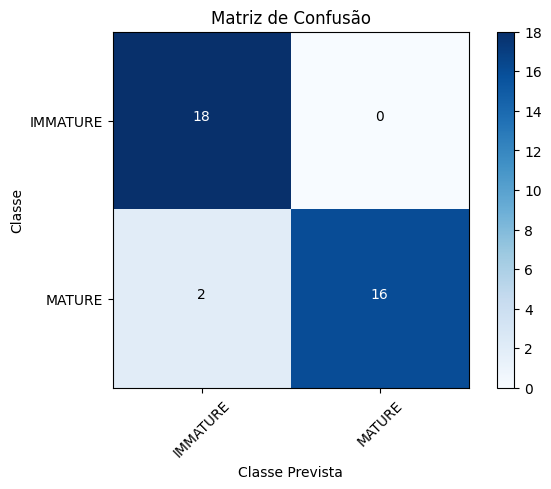

alexnet


<Figure size 640x480 with 0 Axes>

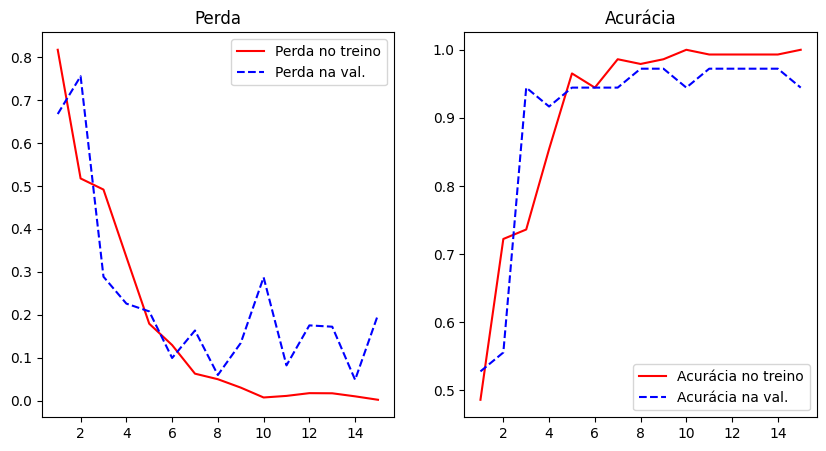

***********************************************************************
vgg


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Época 0/14
----------
Treino Perda: 0.6805 Acurácia: 0.5694 (9.3927 segundos)
Val Perda: 0.5209 Acurácia: 0.8611 (1.7751 segundos)
Tempo: 11s


Época 1/14
----------
Treino Perda: 0.4851 Acurácia: 0.7917 (3.5802 segundos)
Val Perda: 0.3485 Acurácia: 0.8333 (0.8361 segundos)
Tempo: 16s


Época 2/14
----------
Treino Perda: 0.2802 Acurácia: 0.8611 (3.0293 segundos)
Val Perda: 0.1864 Acurácia: 0.9444 (0.7892 segundos)
Tempo: 20s


Época 3/14
----------
Treino Perda: 0.1038 Acurácia: 0.9722 (3.0251 segundos)
Val Perda: 0.1381 Acurácia: 0.9722 (0.7853 segundos)
Tempo: 24s


Época 4/14
----------
Treino Perda: 0.0352 Acurácia: 0.9861 (3.0962 segundos)
Val Perda: 0.1454 Acurácia: 0.9722 (1.0760 segundos)
Tempo: 28s


Época 5/14
----------
Treino Perda: 0.0137 Acurácia: 0.9931 (3.6854 segundos)
Val Perda: 0.1479 Acurácia: 0.9722 (0.8433 segundos)
Tempo: 32s


Época 6/14
----------
Treino Perda: 0.0043 Acurácia: 1.0000 (3.0864 segundos)
Val Perda: 0.1037 Acurácia: 0.9722 (0.8099 segundos)
Tempo

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


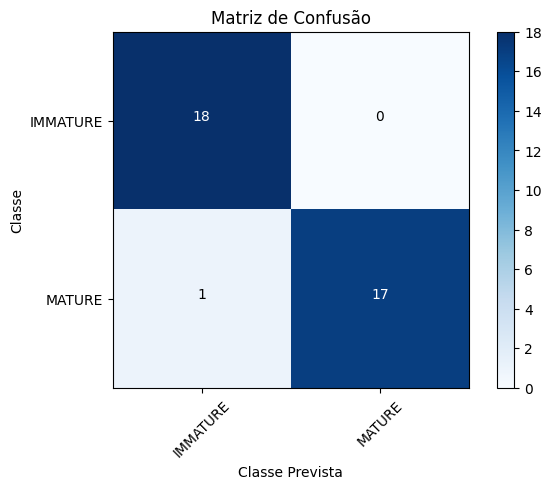

vgg


<Figure size 640x480 with 0 Axes>

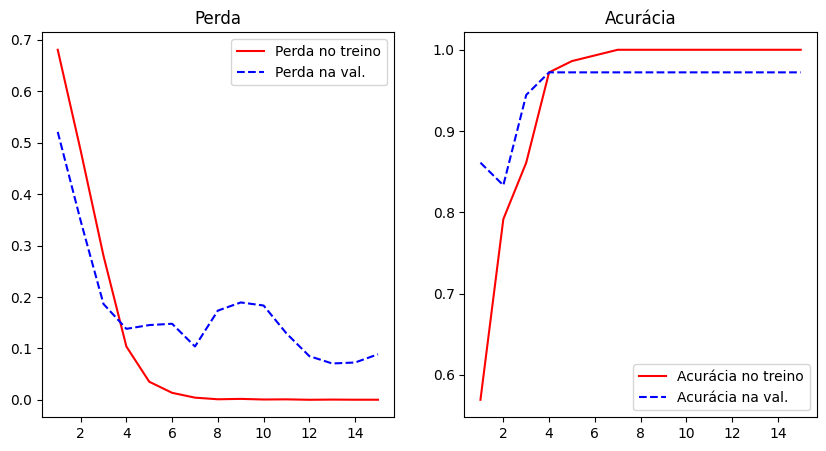

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda")

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

diretorio_treino = "DATASET/dataset_treino"
diretorio_teste = "DATASET/dataset_teste"

conjunto_dados = ImageFolder(diretorio_teste)

if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('\nDispositivo: {0}'.format(device))
    #print(torch.cuda.get_device_name(0))

    for modelo in ['alexnet','vgg']:
        print("***********************************************************************")
        print(modelo)
        parametros_basicos = {
            'num_classes': len(conjunto_dados.classes),
            'class_names': conjunto_dados.classes,
            'batch_size': 32,
            'lr': 0.001,
            'mm': 0.9,
            'epochs': 15,
            'model_name': modelo,
            'criterion': nn.CrossEntropyLoss()
        }

        modelo_ft, tamanho_entrada = inicializar_modelo(parametros_basicos.get('model_name'), parametros_basicos.get('num_classes'))

        transformacoes_dados = {
            'treino': transforms.Compose([
                transforms.Resize([tamanho_entrada, tamanho_entrada], antialias=True),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize([tamanho_entrada, tamanho_entrada], antialias=True),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

        conjunto_treino = datasets.ImageFolder(diretorio_treino, transform=transformacoes_dados['treino'])
        conjunto_teste = datasets.ImageFolder(diretorio_teste, transform=transformacoes_dados['val'])

        carregador_treino = torch.utils.data.DataLoader(conjunto_treino, batch_size=parametros_basicos.get('batch_size'),
                                                        shuffle=True, num_workers=4)
        carregador_val = torch.utils.data.DataLoader(conjunto_teste, batch_size=parametros_basicos.get('batch_size'),
                                                     shuffle=True, num_workers=4)

        dicionario_dataloaders = {'treino': carregador_treino, 'val': carregador_val}

        otimizador = optim.SGD(modelo_ft.parameters(), lr=parametros_basicos.get('lr'), momentum=parametros_basicos.get('mm'))

        data_atual = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        modelo_ft = treinar_modelo(modelo_ft, dicionario_dataloaders, otimizador, parametros_basicos, 1, data_atual, device)